32
12.446363636363637


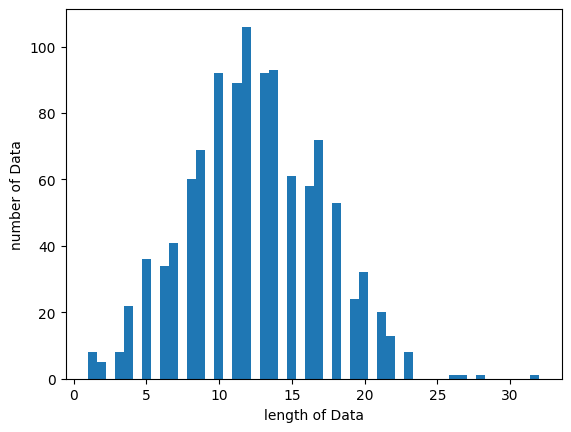

In [51]:
# print( max(len(i) for i in sequences))
# print( sum(map(len, sequences))/len(sequences))
# plt.hist([len(s) for s in sequences], bins = 50)
# plt.xlabel('length of Data')
# plt.ylabel('number of Data')
# plt.show()

<h1>여기서부터 KoBERT시작</h1>

In [4]:
# import
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd
from collections import deque

/home/woong/virtualEnv/coffee/lib/python3.10/site-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [5]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [6]:
# 경로 설정
PATH="./"
#device - GPU 설정
device = torch.device("cuda:0")

In [7]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [8]:
# class BERTSentenceTransform

class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

In [12]:
df = pd.read_csv("output_without_quotes.csv", quoting=1)

data_list = []
for q, label in zip(df['Sentence'], df['Label'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [13]:
#train test split
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, random_state=0)

print(len(dataset_train))
print(len(dataset_test))

880
220


In [9]:
# class BERTDataset
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int64(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [15]:
# 세팅 파라미터
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 15
max_grad_norm = 1
log_interval = 200
learning_rate =  3e-5
max_non_improving_epochs = 3

In [10]:
# class BERTClassifier
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [11]:
#정의한 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

/home/woong/virtualEnv/coffee/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [16]:
# 테스트 데이터 로더
data_test = BERTDataset(dataset_test, 0, 1, tokenizer, vocab, max_len, True, False)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

In [14]:
# 데이터를 X, y로 나누기
X = [item[0] for item in dataset_train]
y = [item[1] for item in dataset_train]

best_val_acc = 0.0

# StratifiedKFold를 사용하여 인덱스 분할
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}/{kfold.get_n_splits()}")

    # 데이터 분할
    train_data = [data_list[i] for i in train_idx]
    val_data = [data_list[i] for i in val_idx]

    # 데이터 로더
    data_train = BERTDataset(train_data, 0, 1, tokenizer, vocab, max_len, True, False)
    data_val = BERTDataset(val_data, 0, 1, tokenizer, vocab, max_len, True, False)

    train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
    val_dataloader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, num_workers=5)

    # 모델 및 옵티마이저 초기화
    model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    t_total = len(train_dataloader) * num_epochs
    warmup_step = int(t_total * warmup_ratio)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

    eval_acc = 0.0
    train_loss_li = []
    train_acc_li = []
    val_loss_li = []
    val_acc_li = []
    non_improving_count = 0
    best_model_state = None

    for e in range(num_epochs):
        train_acc = 0.0
        test_acc = 0.0

        model.train()
        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
            optimizer.zero_grad()
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length= valid_length
            label = label.long().to(device)
            out = model(token_ids, valid_length, segment_ids)

            loss = loss_fn(out, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            scheduler.step()
            train_acc += calc_accuracy(out, label)

            if batch_id % log_interval == 0:
                print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))

        print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
        train_loss_li.append(loss.data.cpu().numpy())
        train_acc_li.append(train_acc / (batch_id+1))

        model.eval()
        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(val_dataloader)):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length= valid_length
            label = label.long().to(device)
            out = model(token_ids, valid_length, segment_ids)
            test_acc += calc_accuracy(out, label)

        print("epoch {} validation loss {} validation acc {}".format(e+1, loss.data.cpu().numpy() ,test_acc / (batch_id+1)))

        val_loss_li.append(loss.data.cpu().numpy())
        val_acc_li.append(test_acc / (batch_id+1))

        if test_acc > eval_acc:
            eval_acc = test_acc
            non_improving_count = 0
            best_model_state = model.state_dict()
            torch.save(model, PATH + f'checkpoint_fold{fold}.pt')  # 해당 fold의 모델 저장
            torch.save(model.state_dict(), PATH + f'model_state_fold{fold}.pt')  # 해당 fold의 모델 state_dict 저장
            torch.save({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict()
            }, PATH + f'all_fold{fold}.tar')  # 해당 fold의 체크포인트 저장
        else:
            non_improving_count += 1

        if non_improving_count >= max_non_improving_epochs:
            print(f"No improvement for {max_non_improving_epochs} epochs. Early stopping.")
            break

    # 추가된 부분: 테스트 데이터에 대한 recall, f1-score 계산
    model.load_state_dict(best_model_state)  # 저장된 최적의 모델로 복원
    model.eval()

    all_preds = []
    all_labels = []

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)

        # 모델 예측
        out = model(token_ids, valid_length, segment_ids)
        _, preds = torch.max(out, 1)

        # 정확도 계산
        test_acc += calc_accuracy(out, label)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

    # recall, f1-score 계산
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

    print(f"Fold {fold + 1}:Precision = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1:.4f}")


/home/woong/virtualEnv/coffee/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Fold 1/5


  9%|███████▋                                                                            | 1/11 [00:01<00:11,  1.11s/it]

epoch 1 batch id 1 loss 0.7049440741539001 train acc 0.46875


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.08it/s]


epoch 1 train acc 0.5198863636363636


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


epoch 1 validation loss 0.7394201159477234 validation acc 0.6041666666666666


  9%|███████▋                                                                            | 1/11 [00:00<00:05,  1.97it/s]

epoch 2 batch id 1 loss 0.5762256979942322 train acc 0.75


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.68it/s]


epoch 2 train acc 0.7073863636363636


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.78it/s]


epoch 2 validation loss 0.5379661917686462 validation acc 0.8854166666666666


  9%|███████▋                                                                            | 1/11 [00:00<00:05,  1.90it/s]

epoch 3 batch id 1 loss 0.4789164662361145 train acc 0.828125


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.65it/s]


epoch 3 train acc 0.8352272727272727


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.39it/s]


epoch 3 validation loss 0.3910291790962219 validation acc 0.8211805555555555


  9%|███████▋                                                                            | 1/11 [00:00<00:03,  2.86it/s]

epoch 4 batch id 1 loss 0.40012142062187195 train acc 0.8125


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.82it/s]


epoch 4 train acc 0.8934659090909091


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.50it/s]


epoch 4 validation loss 0.25545448064804077 validation acc 0.8194444444444445


  9%|███████▋                                                                            | 1/11 [00:00<00:03,  2.79it/s]

epoch 5 batch id 1 loss 0.29448074102401733 train acc 0.90625


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.93it/s]


epoch 5 train acc 0.9303977272727273


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.63it/s]


epoch 5 validation loss 0.18132546544075012 validation acc 0.7934027777777778
No improvement for 3 epochs. Early stopping.


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.27it/s]
/home/woong/virtualEnv/coffee/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Fold 1:Precision = 0.6847, Recall = 1.0000, F1-Score = 0.8128

Fold 2/5


  9%|███████▋                                                                            | 1/11 [00:00<00:03,  3.03it/s]

epoch 1 batch id 1 loss 0.7009943127632141 train acc 0.546875


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.96it/s]


epoch 1 train acc 0.5071022727272727


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.88it/s]


epoch 1 validation loss 0.7014644742012024 validation acc 0.6614583333333334


  9%|███████▋                                                                            | 1/11 [00:00<00:06,  1.53it/s]

epoch 2 batch id 1 loss 0.6070520877838135 train acc 0.640625


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.51it/s]


epoch 2 train acc 0.7414772727272727


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.91it/s]


epoch 2 validation loss 0.425292044878006 validation acc 0.9201388888888888


  9%|███████▋                                                                            | 1/11 [00:00<00:05,  1.79it/s]

epoch 3 batch id 1 loss 0.4732392728328705 train acc 0.8125


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.68it/s]


epoch 3 train acc 0.8863636363636364


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.67it/s]


epoch 3 validation loss 0.19814452528953552 validation acc 0.8559027777777778


  9%|███████▋                                                                            | 1/11 [00:00<00:03,  2.76it/s]

epoch 4 batch id 1 loss 0.3822648525238037 train acc 0.84375


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.95it/s]


epoch 4 train acc 0.8977272727272727


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.23it/s]


epoch 4 validation loss 0.2193126529455185 validation acc 0.9548611111111112


  9%|███████▋                                                                            | 1/11 [00:00<00:05,  2.00it/s]

epoch 5 batch id 1 loss 0.3296426832675934 train acc 0.875


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.69it/s]


epoch 5 train acc 0.8948863636363636


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.16it/s]


epoch 5 validation loss 0.20181436836719513 validation acc 0.9375


  9%|███████▋                                                                            | 1/11 [00:00<00:03,  2.57it/s]

epoch 6 batch id 1 loss 0.27216461300849915 train acc 0.890625


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.93it/s]


epoch 6 train acc 0.9417613636363636


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.65it/s]


epoch 6 validation loss 0.1487387716770172 validation acc 0.9201388888888888


  9%|███████▋                                                                            | 1/11 [00:00<00:03,  2.66it/s]

epoch 7 batch id 1 loss 0.24685867130756378 train acc 0.90625


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.93it/s]


epoch 7 train acc 0.953125


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.29it/s]


epoch 7 validation loss 0.11977105587720871 validation acc 0.90625
No improvement for 3 epochs. Early stopping.


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]
/home/woong/virtualEnv/coffee/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Fold 2:Precision = 0.9610, Recall = 0.9737, F1-Score = 0.9673

Fold 3/5


  9%|███████▋                                                                            | 1/11 [00:00<00:03,  3.08it/s]

epoch 1 batch id 1 loss 0.3519638478755951 train acc 0.9375


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.96it/s]


epoch 1 train acc 0.9446022727272727


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.76it/s]


epoch 1 validation loss 0.2554604709148407 validation acc 0.9791666666666666


  9%|███████▋                                                                            | 1/11 [00:00<00:06,  1.58it/s]

epoch 2 batch id 1 loss 0.22398412227630615 train acc 0.953125


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.59it/s]


epoch 2 train acc 0.953125


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.98it/s]


epoch 2 validation loss 0.1603022813796997 validation acc 0.9409722222222222


  9%|███████▋                                                                            | 1/11 [00:00<00:03,  2.98it/s]

epoch 3 batch id 1 loss 0.13833586871623993 train acc 0.96875


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.99it/s]


epoch 3 train acc 0.9616477272727273


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.52it/s]


epoch 3 validation loss 0.11809253692626953 validation acc 0.9375


  9%|███████▋                                                                            | 1/11 [00:00<00:03,  3.22it/s]

epoch 4 batch id 1 loss 0.1414417028427124 train acc 0.96875


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.04it/s]


epoch 4 train acc 0.9616477272727273


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.02it/s]


epoch 4 validation loss 0.06448045372962952 validation acc 0.9375
No improvement for 3 epochs. Early stopping.


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.99it/s]
/home/woong/virtualEnv/coffee/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Fold 3:Precision = 0.9367, Recall = 0.9737, F1-Score = 0.9548

Fold 4/5


  9%|███████▋                                                                            | 1/11 [00:00<00:03,  3.02it/s]

epoch 1 batch id 1 loss 0.5331048369407654 train acc 0.828125


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.89it/s]


epoch 1 train acc 0.8465909090909091


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.38it/s]


epoch 1 validation loss 0.4077312648296356 validation acc 0.984375


  9%|███████▋                                                                            | 1/11 [00:00<00:06,  1.59it/s]

epoch 2 batch id 1 loss 0.41766154766082764 train acc 0.9375


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.59it/s]


epoch 2 train acc 0.9602272727272727


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.62it/s]


epoch 2 validation loss 0.17489494383335114 validation acc 0.9739583333333334


  9%|███████▋                                                                            | 1/11 [00:00<00:03,  2.99it/s]

epoch 3 batch id 1 loss 0.1760384738445282 train acc 0.9375


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.93it/s]


epoch 3 train acc 0.9644886363636364


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.99it/s]


epoch 3 validation loss 0.07599371671676636 validation acc 0.9305555555555555


  9%|███████▋                                                                            | 1/11 [00:00<00:03,  2.69it/s]

epoch 4 batch id 1 loss 0.13217169046401978 train acc 0.96875


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.95it/s]


epoch 4 train acc 0.9772727272727273


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.03it/s]


epoch 4 validation loss 0.0822712853550911 validation acc 0.9357638888888888
No improvement for 3 epochs. Early stopping.


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]
/home/woong/virtualEnv/coffee/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Fold 4:Precision = 0.9615, Recall = 0.9868, F1-Score = 0.9740

Fold 5/5


  9%|███████▋                                                                            | 1/11 [00:00<00:03,  3.08it/s]

epoch 1 batch id 1 loss 0.9151598811149597 train acc 0.109375


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.98it/s]


epoch 1 train acc 0.30113636363636365


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.47it/s]


epoch 1 validation loss 0.618646502494812 validation acc 0.9722222222222222


  9%|███████▋                                                                            | 1/11 [00:00<00:06,  1.61it/s]

epoch 2 batch id 1 loss 0.5364415645599365 train acc 0.828125


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.58it/s]


epoch 2 train acc 0.921875


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.88it/s]


epoch 2 validation loss 0.1823844164609909 validation acc 0.9722222222222222


  9%|███████▋                                                                            | 1/11 [00:00<00:03,  3.12it/s]

epoch 3 batch id 1 loss 0.18404746055603027 train acc 0.96875


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.99it/s]


epoch 3 train acc 0.9502840909090909


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.36it/s]


epoch 3 validation loss 0.07726801931858063 validation acc 0.9791666666666666


  9%|███████▋                                                                            | 1/11 [00:00<00:04,  2.21it/s]

epoch 4 batch id 1 loss 0.1498614102602005 train acc 0.96875


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.81it/s]


epoch 4 train acc 0.9573863636363636


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.37it/s]


epoch 4 validation loss 0.07081420719623566 validation acc 0.9774305555555555


  9%|███████▋                                                                            | 1/11 [00:00<00:03,  3.19it/s]

epoch 5 batch id 1 loss 0.15171226859092712 train acc 0.96875


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.04it/s]


epoch 5 train acc 0.9573863636363636


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.10it/s]


epoch 5 validation loss 0.08975248783826828 validation acc 0.9704861111111112


  9%|███████▋                                                                            | 1/11 [00:00<00:03,  3.10it/s]

epoch 6 batch id 1 loss 0.15109407901763916 train acc 0.96875


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.99it/s]


epoch 6 train acc 0.9701704545454546


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.20it/s]


epoch 6 validation loss 0.0818895623087883 validation acc 0.9600694444444445
No improvement for 3 epochs. Early stopping.


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.40it/s]

Fold 5:Precision = 0.9367, Recall = 0.9737, F1-Score = 0.9548


In [16]:
model = torch.load(PATH + 'checkpoint.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
model.load_state_dict(torch.load(PATH + 'model_state.pt'))  # state_dict를 불러 온 후, 모델에 저장

checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [17]:
def get_train_result():
    best_acc = 0
    best_model = 0
    for i in range(5):
        model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
        model.load_state_dict(torch.load(PATH + f'model_state_fold{i}.pt'))
        model.eval()

        all_preds = []
        all_labels = []


        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length= valid_length
            label = label.long().to(device)

            # 모델 예측
            out = model(token_ids, valid_length, segment_ids)
            _, preds = torch.max(out, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

        # recall, f1-score 계산
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=1)
        accuracy = accuracy_score(all_labels, all_preds)
        if accuracy>best_acc:
            best_acc = accuracy
            best_model = i

        print(f"Fold {i + 1}:Precision = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1:.4f}, Accuracy = {accuracy:.4f}")

    return best_model

# 예측 함수
def predict(predict_sentence, best_model):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)
    all_test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
    model.load_state_dict(torch.load(PATH + f'model_state_fold{best_model}.pt'))
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(all_test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

    out = model(token_ids, valid_length, segment_ids)

# 행복, 놀람, 분노, 공포, 혐오, 슬픔, 중립
    test_eval=[]
    for i in out:
        logits=i
        logits = logits.detach().cpu().numpy()

        if np.argmax(logits) == 0:
            test_eval.append("아무것도 안")
        elif np.argmax(logits) == 1:
            test_eval.append("추출이")

    print(test_eval[0] + " 느껴집니다.")

<h3>레시피와 관련된 문장을 분류하는지 확인해보기</h3>

In [16]:
#질문 무한반복하기! 0 입력시 종료
end = 1
best_model = get_train_result()
while end == 1 :
    sentence = input("추출 레시피를 입력해주세요 : ")
    if sentence == '0' :
        break
    predict(sentence, best_model)
    print("\n")

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.53it/s]


Fold 1:Precision = 0.8736, Recall = 0.8727, F1-Score = 0.8731, Accuracy = 0.8727


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.98it/s]


Fold 2:Precision = 0.9697, Recall = 0.9682, F1-Score = 0.9684, Accuracy = 0.9682


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.11it/s]


Fold 3:Precision = 0.9737, Recall = 0.9727, F1-Score = 0.9729, Accuracy = 0.9727


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.15it/s]


Fold 4:Precision = 0.9709, Recall = 0.9682, F1-Score = 0.9685, Accuracy = 0.9682


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.09it/s]


Fold 5:Precision = 0.9529, Recall = 0.9455, F1-Score = 0.9463, Accuracy = 0.9455


추출 레시피를 입력해주세요 :  안녕하세요


아무것도 안 느껴집니다.




추출 레시피를 입력해주세요 :  이번 추출에서는 하리오 v60을 사용하여 파나마 하트만 게이샤를 추출해보겠습니다


추출이 느껴집니다.




추출 레시피를 입력해주세요 :  하리오 v60는 세라믹을 사용하고 있고 추출 전에 린싱과 예열을 해주는 것이 아주 중요합니다.


아무것도 안 느껴집니다.




추출 레시피를 입력해주세요 :  이번 추출에서는 원두 20g을 사용하여 추출할 예정이고 1:15비율로 진행하겠습니다


추출이 느껴집니다.




추출 레시피를 입력해주세요 :  처음에 추출을 시작하시면서 물을 푸어하기 전에 꼭 타이머를 먼저 시작해주셔야 합니다.


아무것도 안 느껴집니다.




추출 레시피를 입력해주세요 :  처음에는 40초동안 40g의 물로 뜸을 들여주세요


추출이 느껴집니다.




추출 레시피를 입력해주세요 :  이후 40초가 되면 180g을 추가로 부어줍니다


추출이 느껴집니다.




추출 레시피를 입력해주세요 :  마지막으로 1분 30초가 되면 나머지 80g을 추가로 추출해주겠습니다.


추출이 느껴집니다.




추출 레시피를 입력해주세요 :  0


In [17]:
#질문 무한반복하기! 0 입력시 종료
end = 1
best_model = get_train_result()
while end == 1 :
    sentence = input("추출 레시피를 입력해주세요 : ")
    if sentence == '0' :
        break
    predict(sentence, best_model)
    print("\n")

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.29s/it]


Fold 1:Precision = 0.8736, Recall = 0.8727, F1-Score = 0.8731, Accuracy = 0.8727


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.20s/it]


Fold 2:Precision = 0.9697, Recall = 0.9682, F1-Score = 0.9684, Accuracy = 0.9682


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.20s/it]


Fold 3:Precision = 0.9737, Recall = 0.9727, F1-Score = 0.9729, Accuracy = 0.9727


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.17s/it]


Fold 4:Precision = 0.9709, Recall = 0.9682, F1-Score = 0.9685, Accuracy = 0.9682


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.19s/it]


Fold 5:Precision = 0.9529, Recall = 0.9455, F1-Score = 0.9463, Accuracy = 0.9455


추출 레시피를 입력해주세요 :  분쇄도는 ek43s 기준으로 13입니다.


추출이 느껴집니다.




추출 레시피를 입력해주세요 :  군세도는 2, k 43 s 기준으로 13입니다.


추출이 느껴집니다.




추출 레시피를 입력해주세요 :  기준으로 13입니다.


추출이 느껴집니다.




추출 레시피를 입력해주세요 :  13입니다.


추출이 느껴집니다.




추출 레시피를 입력해주세요 :  13초동안 춤을 추세요


추출이 느껴집니다.




추출 레시피를 입력해주세요 :  후르티 버전 2에서는 요


아무것도 안 느껴집니다.




추출 레시피를 입력해주세요 :  13분동안 마시겠습니다.


추출이 느껴집니다.




추출 레시피를 입력해주세요 :  0
